#### Functions used in this project

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import warnings
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from imageio import imread
from matplotlib.colors import LightSource
import pandas as pd
import sys

#Scaling the digital terrain data.
def max_min_scale(data):
    shape=data.shape
    data=data.flatten()
    data=(data - data.min(axis=0, keepdims=True)) / (data.max(axis=0, keepdims=True) - data.min(axis=0, keepdims=True))
    return data.reshape(shape)

#Franke's function.
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

#Creating and formatting the x, y, and z coordinates for Franke's function.
def test_function(sigma,h):
    x = np.arange(0, 1, h)
    y = np.arange(0, 1, h)
    x, y = np.meshgrid(x,y)
    z = FrankeFunction(x, y)+np.random.normal(0, sigma, x.shape)
    data=np.zeros((np.shape(y.flatten())[0], 2))
    data[:,0]=y.flatten()
    data[:,1]=x.flatten()
    return data, z.flatten()

#Selecting a 400x400 section from the terrain data.
def terrain_data():
    terrain = imread('SRTM_data_Norway_1.tif')
    N = 3601
    terrain = terrain[:N,:N]
    x = np.linspace(0,np.shape(terrain)[1], np.shape(terrain)[0])
    y = np.linspace(0,np.shape(terrain)[0], np.shape(terrain)[0])
    print("The entire terrain: ","Minimum altitude: ",min(terrain.flatten()),"Maximum altitude: ",max(terrain.flatten()))
    x_mesh, y_mesh = np.meshgrid(x,y)
    
    start_x=1000
    start_y=180
    n_datapoints=400
    z=np.array(terrain[np.arange(n_datapoints)+start_y, :][:, np.arange(n_datapoints)+start_x],dtype=np.longdouble)
    x_mesh=np.array(x_mesh[np.arange(n_datapoints)+start_x, :][:, np.arange(n_datapoints)+start_x],dtype=np.longdouble)
    y_mesh=np.array(y_mesh[np.arange(n_datapoints)+start_y, :][:, np.arange(n_datapoints)+start_y],dtype=np.longdouble)
    
    print("Custom terrain: ","Minimum altitude: ",min(z.flatten()),"Maximum altitude: ",max(z.flatten()))
    x_mesh=max_min_scale(x_mesh)
    y_mesh=max_min_scale(y_mesh)
    z_mesh=(((z.ravel())/(max(z.ravel())))*1.22).reshape(z.shape)
    return x_mesh, y_mesh,z_mesh

#Creating the feature matrix.
def feature_matrix(x,y,n):
    #Consistent with sklearn
    #1,x,y,x^2,xy,y^2,x^3,x^2y,xy^2,y^3,...
    p_exp=[]
    n_beta=int((n+1)*(n+2)/2)
    x=x.flatten()
    y=y.flatten()
    
    for i in range(n+2):
        for j in range(i):
            p_exp.append([i-j-1,j])
    X= np.zeros((np.shape(y)[0], n_beta-1))
    for d in range(1, n_beta):
        X[:, d-1] = ((x**p_exp[d][0])*(y**p_exp[d][1]))
    return X

#Calculating the Mean Squared Error (MSE).
def MSE(x,y):
    return (1/np.size(x))*np.sum((x-y)**2)

#Calcultaing the R-squared ($R^2$) score.
def R2(x,y):
    return 1-(np.sum((x-y)**2))/np.sum((x-np.mean(x))**2)

#Investigating how noise affects Ridge regression.
def Ridge_noise(x_train, x_test, y_train, y_test,deg,lmb):
    X_train = feature_matrix(x_train[:,0],x_train[:,1],deg)
    X_test = feature_matrix(x_test[:,0],x_test[:,1],deg)
    X_train_mean=np.mean(X_train,axis=0)
    X_train_scaled =  X_train-X_train_mean
    X_test_scaled = X_test-X_train_mean
    y_scaler = np.mean(y_train)
    y_train_scaled = y_train - y_scaler
    y_test_scaled = y_test 

    I_matrix=np.eye(X_train_scaled.shape[1])
    beta_scaled = np.linalg.pinv(X_train_scaled.T.dot(X_train_scaled)+
                                 lmb*I_matrix).dot(X_train_scaled.T).dot(np.ravel(y_train_scaled))
    y_train_tilde = X_train_scaled@beta_scaled
    y_test_tilde = X_test_scaled@beta_scaled+ y_scaler
    r2_train=1-(np.sum((y_train_scaled-y_train_tilde)**2))/np.sum((y_train_scaled-np.mean(y_train_scaled))**2)
    r2_test= 1-(np.sum((y_test_scaled-y_test_tilde)**2))/np.sum((y_test_scaled-np.mean(y_test_scaled))**2)
    return r2_train,r2_test

#My implementation includes bootstrapping for OLS and Ridge, whereas I use scikit-learn for LASSO.
def bootstraps(n_boostraps,maxdegree,model,x_train, x_test, y_train, y_test,find_optimal):
    error = np.zeros(maxdegree)
    bias = np.zeros(maxdegree)
    variance = np.zeros(maxdegree)
    train_error=[0]*maxdegree
    test_error=[0]*maxdegree
    degree_p=[0]*maxdegree
    y_test=y_test.reshape(np.size(y_test),1) 
    if model =="OLS":
        if find_optimal=="True":
            start_degree=maxdegree
        else:
            start_degree=1
            
        for deg in range(start_degree,maxdegree+1):
            X_test = feature_matrix(x_test[:,0],x_test[:,1],deg)
            y_pred = np.empty((y_test.shape[0], n_boostraps))
            fit_error = np.empty((y_train.shape[0], n_boostraps))
            beta_values=[0]*n_boostraps
            for i in range(n_boostraps):
                x_, y_ = resample(x_train, y_train)
                X_train = feature_matrix(x_[:,0],x_[:,1],deg)
                X_train_mean=np.mean(X_train, keepdims=True)
                X_train_scaled = X_train-X_train_mean
                X_test_scaled = X_test-X_train_mean
                y_scaler=np.mean(y_)
                y_train_scaled=y_-y_scaler
                beta_scaled = np.linalg.pinv(X_train_scaled.T.dot(X_train_scaled)).dot(X_train_scaled.T).dot(np.ravel(y_train_scaled))
                y_train_tilde = X_train_scaled@beta_scaled
                y_test_tilde = X_test_scaled@beta_scaled+y_scaler
                y_pred[:, i] = y_test_tilde
                y_train_scaled=y_train.reshape(np.size(y_train_scaled),)
                fit_error[:, i] = y_- y_train_tilde-np.mean(y_train)
                beta_values[i]=beta_scaled
                b0=np.mean(y_train)- np.mean(np.dot(feature_matrix(x_train[:,0],x_train[:,1],deg),beta_scaled))
                beta_values[i]=np.insert(beta_values[i], 0,b0)

            degree_p[deg-1] = deg
            error[deg-1] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
            bias[deg-1] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
            variance[deg-1] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
            test_error[deg-1] =np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
            train_error[deg-1] =np.mean( np.mean((fit_error)**2, axis=1, keepdims=True) )
        return degree_p,error,bias,variance,test_error,train_error,[beta_values,error[deg-1]]

    if model =="Ridge" or model =="LASSO":
        if find_optimal=="True":
            #This is will take time given the array is 1000 lambda values.
            #Lambda=np.sort(np.unique(np.hstack([(np.arange(100)/(-10*10**i)) for i in range(1,12)])))
            
            Lambda=np.logspace(-8, 0, 30)
        else:
            Lambda=np.logspace(-8, 8, 100)
            
        lowest_mse=np.inf
        deg=maxdegree
        
        n_lambda=len(Lambda)
        train_error=[0]*n_lambda
        test_error=[0]*n_lambda  
        error = np.zeros(n_lambda)
        bias = np.zeros(n_lambda)
        variance = np.zeros(n_lambda)
        X_test = feature_matrix(x_test[:,0],x_test[:,1],maxdegree)
        degree_p=[0]*n_lambda
        
        for deg in range(n_lambda):
            y_pred = np.empty((y_test.shape[0], n_boostraps))
            fit_error = np.empty((y_train.shape[0], n_boostraps))
            beta_values=[0]*n_boostraps
            
            for i in range(n_boostraps):
                
                if model =="Ridge":
                    x_, y_ = resample(x_train, y_train)
                    X_train = feature_matrix(x_[:,0],x_[:,1],maxdegree)
                    X_train_mean=np.mean(X_train, keepdims=True)
                    X_train_scaled = X_train-X_train_mean
                    I_matrix=np.eye(X_train_scaled.shape[1])
                    X_test_scaled = X_test-X_train_mean
                    y_scaler=np.mean(y_)
                    y_train_scaled=y_-y_scaler
                    beta_scaled = np.linalg.pinv(X_train_scaled.T.dot(X_train_scaled)+
                                                 Lambda[deg]*I_matrix).dot(X_train_scaled.T).dot(np.ravel(y_train_scaled))
                    y_train_tilde = X_train_scaled@beta_scaled
                    y_test_tilde = X_test_scaled@beta_scaled+y_scaler
                    y_pred[:, i] = y_test_tilde
                    y_train_scaled=y_train.reshape(np.size(y_train_scaled),)
                    fit_error[:, i] = y_- y_train_tilde-np.mean(y_train)
                    beta_values[i]=beta_scaled
                    b0=np.mean(y_train)- np.mean(np.dot(feature_matrix(x_train[:,0],x_train[:,1],maxdegree),beta_scaled))
                    beta_values[i]=np.insert(beta_values[i], 0,b0)
                    
                if model =="LASSO":
                    x_, y_ = resample(x_train, y_train)
                    X_train = feature_matrix(x_[:,0],x_[:,1],maxdegree)
                    RegLasso = linear_model.Lasso(Lambda[deg], fit_intercept=True)
                    RegLasso.fit(X_train,y_)
                    y_train_tilde = RegLasso.predict(X_train)
                    y_test_tilde = RegLasso.predict(X_test)
                    y_pred[:, i] = y_test_tilde
                    fit_error[:, i] = y_- y_train_tilde
                    beta_scaled = RegLasso.coef_
                    beta_values[i]=beta_scaled
                    b0=np.mean(y_train)- np.mean(np.dot(feature_matrix(x_train[:,0],x_train[:,1],maxdegree),beta_scaled))
                    beta_values[i]=np.insert(beta_values[i], 0,b0)
            
            degree_p[deg] = deg
            error[deg] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
            bias[deg] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
            variance[deg] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
            test_error[deg] =np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
            train_error[deg] =np.mean( np.mean((fit_error)**2, axis=1, keepdims=True) )
            
            if error[deg]<lowest_mse:
                best_lambda=Lambda[deg]
                lowest_mse=error[deg]
                best_beta_values=beta_values
                
        return np.log10(Lambda),error,bias,variance,test_error,train_error,[best_beta_values,lowest_mse,best_lambda]
    
#Cross-validation using K-folds..    
def K_fold(z,p,k,model):
    if model=="Ridge" or model=="LASSO":
        nlambdas = 100
        lambdas=np.logspace(-8, 8, nlambdas)
        k = 10
        scores_KFold_test = np.zeros((nlambdas, k))
        scores_KFold_train = np.zeros((nlambdas, k))
        rng = np.random.default_rng()
        data_size=len(z)
        a=(np.full((nlambdas, data_size), np.arange(data_size)))
    
        for i in range(nlambdas):
            lmb = lambdas[i]
            #rng.shuffle(a[i])
            for j in range(k):
                kfold_indices=np.split(a[i],k)
                test_indices=np.sort(kfold_indices[j])
                kfold_indices.pop(j)
                train_indices=np.sort(np.concatenate((kfold_indices), axis=None)) 
                x_train = data[train_indices]
                x_test = data[test_indices]
            
                y_train = z[train_indices]
                y_test = z[test_indices]
                X_train = feature_matrix(x_train[:,0],x_train[:,1],p)
                
                I=np.eye(X_train.shape[1])
                
                X_test = feature_matrix(x_test[:,0],x_test[:,1],p)
                X_train_mean=np.mean(X_train,axis=0)
                
                y_scaler=np.mean(y_train)
                X_train_scaled=X_train-X_train_mean
                X_test_scaled=X_test-X_train_mean
                y_train_scaled=y_train-y_scaler
                beta_scaled = np.linalg.pinv(X_train_scaled.T @ X_train_scaled+lmb*I) @ X_train_scaled.T @ y_train_scaled
                if model=="LASSO":
                    RegLasso = linear_model.Lasso(lambdas[i], fit_intercept=True)
                    RegLasso.fit(X_train,y_train)
                    y_train_tilde = RegLasso.predict(X_train)
                    y_pred = RegLasso.predict(X_test)
                    scores_KFold_test[i,j] =MSE(y_pred,y_test)
                    scores_KFold_train[i,j] =MSE(y_train_tilde,y_train)
                
                if model=="Ridge":
                    y_train_tilde = X_train_scaled@beta_scaled
                    y_test_tilde = X_test_scaled@beta_scaled
                    y_pred = y_test_tilde+y_scaler
                    scores_KFold_test[i,j] =MSE(y_pred,y_test)
                    scores_KFold_train[i,j] =MSE(y_train_tilde,y_train_scaled)
            estimated_mse_KFold_train = np.mean(scores_KFold_train, axis = 1)
            estimated_mse_KFold_test = np.mean(scores_KFold_test, axis = 1)
                    
    if model=="OLS":
        n_kfold_cross_test=[0]*k
        for n_kfold in range(k):
            
            scores_KFold_test = np.zeros((p, k))
            scores_KFold_train = np.zeros((p, k))
            rng = np.random.default_rng()
            data_size=len(z)
            a=(np.full((p, data_size), np.arange(data_size)))
            for i in range(1,p+1):
                rng.shuffle(a[i-1])
                for j in range(k):
                    kfold_indices=np.split(a[i-1],k)
                    test_indices=np.sort(kfold_indices[j])
                    kfold_indices.pop(j)
                    train_indices=np.sort(np.concatenate((kfold_indices), axis=None)) 
                    x_train = data[train_indices]
                    x_test = data[test_indices]
            
                    y_train = z[train_indices]
                    y_test = z[test_indices]
        
                    X_train = feature_matrix(x_train[:,0],x_train[:,1],i)
                    X_test = feature_matrix(x_test[:,0],x_test[:,1],i)
        
                    X_train_mean=np.mean(X_train,axis=0)
                    y_scaler=np.mean(y_train)
                    X_train_scaled=X_train-X_train_mean
                    X_test_scaled=X_test-X_train_mean
                    y_train_scaled=y_train-y_scaler
                    beta_scaled = np.linalg.pinv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ y_train_scaled
                
                    y_train_tilde = X_train_scaled@beta_scaled
                    y_test_tilde = X_test_scaled@beta_scaled
                    y_pred = y_test_tilde+y_scaler
                    scores_KFold_test[i-1,j] =MSE(y_pred,y_test)
                    scores_KFold_train[i-1,j] =MSE(y_train_tilde,y_train_scaled)
        
            estimated_mse_KFold_train = np.mean(scores_KFold_train, axis = 1)
            estimated_mse_KFold_test = np.mean(scores_KFold_test, axis = 1)
            n_kfold_cross_test[n_kfold]=estimated_mse_KFold_test
        n_kfold_cross_test=np.mean(np.stack(n_kfold_cross_test),axis=0)
  
    if model=="Ridge" or model=="LASSO":
        return np.log10(lambdas),estimated_mse_KFold_train,estimated_mse_KFold_test
    
    if model=="OLS":
        return np.arange(1,p+1),estimated_mse_KFold_train,n_kfold_cross_test
    
#The cross_val_score function provided by scikit-learn.
def cross_val(data,z,method,p):
    lambdas = np.logspace(-8, 8, 100)
    estimated_mse_sklearn = np.zeros(100)
    if method=="OLS":
        estimated_mse_sklearn = np.zeros(p)
        for i in range(1,p+1):
            X = feature_matrix(data[:,0],data[:,1],i)
            model = LinearRegression(fit_intercept=True)
            estimated_mse_folds = cross_val_score(model, X, z[:, np.newaxis], scoring='neg_mean_squared_error', cv=100)
            estimated_mse_sklearn[i-1] = np.mean(-estimated_mse_folds)
        return np.arange(1,p+1),estimated_mse_sklearn
        
    i = 0
    for lmb in lambdas:
        if method=="Ridge":
            model=Ridge(alpha = lmb, fit_intercept=True)
        if method=="LASSO":
            model=Lasso(alpha = lmb, fit_intercept=True) 
            
        X = feature_matrix(data[:,0],data[:,1],p)
        estimated_mse_folds = cross_val_score(model, X, z[:, np.newaxis], scoring='neg_mean_squared_error', cv=10)
        estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)
        i += 1
        
    return np.log10(lambdas),estimated_mse_sklearn

#Regression methods implemented in both my custom code and scikit-learn. 
#This enables me to conduct comparisons and validate the accuracy of my implementations across various methods.
def regression_methods(x_train, x_test, y_train, y_test,p,model):
    maxdegree=p
    n_beta=int((maxdegree+1)*(maxdegree+2)/2)-1
      
    if model=="OLS" or model=="OLS sklearn":
        train_error=[0]*maxdegree
        test_error=[0]*maxdegree
        degree_p=[0]*maxdegree
        r2_train=[0]*maxdegree
        r2_test=[0]*maxdegree
        beta_values=[0]*maxdegree
        for deg in range(1,maxdegree+1):
            X_train = feature_matrix(x_train[:,0],x_train[:,1],deg)
            X_test = feature_matrix(x_test[:,0],x_test[:,1],deg)
            
            if model=="OLS":
                X_train_mean=np.mean(X_train,axis=0)
                X_train_scaled =  X_train-X_train_mean
                X_test_scaled = X_test-X_train_mean
                y_scaler = np.mean(y_train)
                y_train_scaled = y_train - y_scaler
                y_test_scaled = y_test 
                beta_scaled = np.linalg.pinv(X_train_scaled.T.dot(X_train_scaled)).dot(X_train_scaled.T).dot(np.ravel(y_train_scaled))
                y_train_tilde = X_train_scaled@beta_scaled
                y_test_tilde = X_test_scaled@beta_scaled+ y_scaler 
                train_error[deg-1]= MSE(y_train_scaled, y_train_tilde)
                test_error[deg-1] = MSE(y_test_scaled, y_test_tilde)
                r2_train[deg-1]=R2(y_train_scaled, y_train_tilde)
                r2_test[deg-1]= R2(y_test_scaled, y_test_tilde)
                degree_p[deg-1]=deg
                beta_values[deg-1]= np.array(np.concatenate((beta_scaled,[0]*(n_beta-len(beta_scaled))), axis=None))
                
            if model=="OLS sklearn":
                RegOLS = linear_model.LinearRegression(fit_intercept=True)
                RegOLS.fit(X_train,y_train)
                y_train_tilde = RegOLS.predict(X_train)
                y_test_tilde = RegOLS.predict(X_test)
                test_error[deg-1] = MSE(y_test,y_test_tilde)
                train_error[deg-1] = MSE(y_train,y_train_tilde)
                r2_train[deg-1]=R2(y_train, y_train_tilde)
                r2_test[deg-1]= R2(y_test, y_test_tilde)
                beta_values[deg-1]= RegOLS.coef_
                degree_p[deg-1]=deg

        return degree_p,train_error,test_error,r2_train,r2_test,beta_values

    if model=="Ridge" or "LASSO" or "Ridge sklearn":
        Lambda=np.logspace(-8, 8, 1000)
        n_lambda=len(Lambda)
        train_error=[0]*n_lambda
        test_error=[0]*n_lambda
        degree_p=[0]*n_lambda
        r2_train=[0]*n_lambda
        r2_test=[0]*n_lambda
        beta_values=[0]*n_lambda
        X_train = feature_matrix(x_train[:,0],x_train[:,1],maxdegree)
        X_test = feature_matrix(x_test[:,0],x_test[:,1],maxdegree)
        X_train_mean=np.mean(X_train,axis=0)
        X_train_scaled = X_train-X_train_mean
        X_test_scaled =X_test- X_train_mean
        y_scaler = np.mean(y_train)
        y_train_scaled = y_train - y_scaler
        y_test_scaled = y_test 
        I_matrix=np.eye(X_train_scaled.shape[1])
        for lmb in range(n_lambda):
            if model=="Ridge":
                beta_scaled = np.linalg.pinv(X_train_scaled.T.dot(X_train_scaled)+
                                         Lambda[lmb]*I_matrix).dot(X_train_scaled.T).dot(np.ravel(y_train_scaled))
                y_train_tilde = X_train_scaled@beta_scaled
                y_test_tilde = X_test_scaled@beta_scaled+ y_scaler
                train_error[lmb]= MSE(y_train_scaled, y_train_tilde)
                test_error[lmb] = MSE(y_test_scaled, y_test_tilde)
                r2_train[lmb]=R2(y_train_scaled, y_train_tilde)
                r2_test[lmb]= R2(y_test_scaled, y_test_tilde)
                degree_p[lmb]=Lambda[lmb]
                beta_values[lmb]= np.array(np.concatenate((beta_scaled,[0]*(n_beta-len(beta_scaled))), axis=None))
                
            if model=="LASSO":
                RegLasso = linear_model.Lasso(Lambda[lmb], fit_intercept=True)
                RegLasso.fit(X_train,y_train)
                y_train_tilde = RegLasso.predict(X_train)
                y_test_tilde = RegLasso.predict(X_test)
                test_error[lmb] = MSE(y_test,y_test_tilde)
                train_error[lmb] = MSE(y_train,y_train_tilde)
                beta_values[lmb]= RegLasso.coef_
                degree_p[lmb]=Lambda[lmb]
                r2_train[lmb]=R2(y_train, y_train_tilde)
                r2_test[lmb]= R2(y_test, y_test_tilde)
                
            if model=="Ridge sklearn":
                RegRidge = linear_model.Ridge(Lambda[lmb], fit_intercept=True)
                RegRidge.fit(X_train,y_train)
                y_train_tilde = RegRidge.predict(X_train)
                y_test_tilde = RegRidge.predict(X_test)
                test_error[lmb] = MSE(y_test,y_test_tilde)
                train_error[lmb] = MSE(y_train,y_train_tilde)
                beta_values[lmb]= RegRidge.coef_
                degree_p[lmb]=Lambda[lmb]
                r2_train[lmb]=R2(y_train, y_train_tilde)
                r2_test[lmb]= R2(y_test, y_test_tilde)
    
        beta_values=np.stack(beta_values)
        return np.log10(degree_p),train_error,test_error,r2_train,r2_test,beta_values

## The Franke's Function

#### The $R^2$ score and Mean Squared Error (MSE).

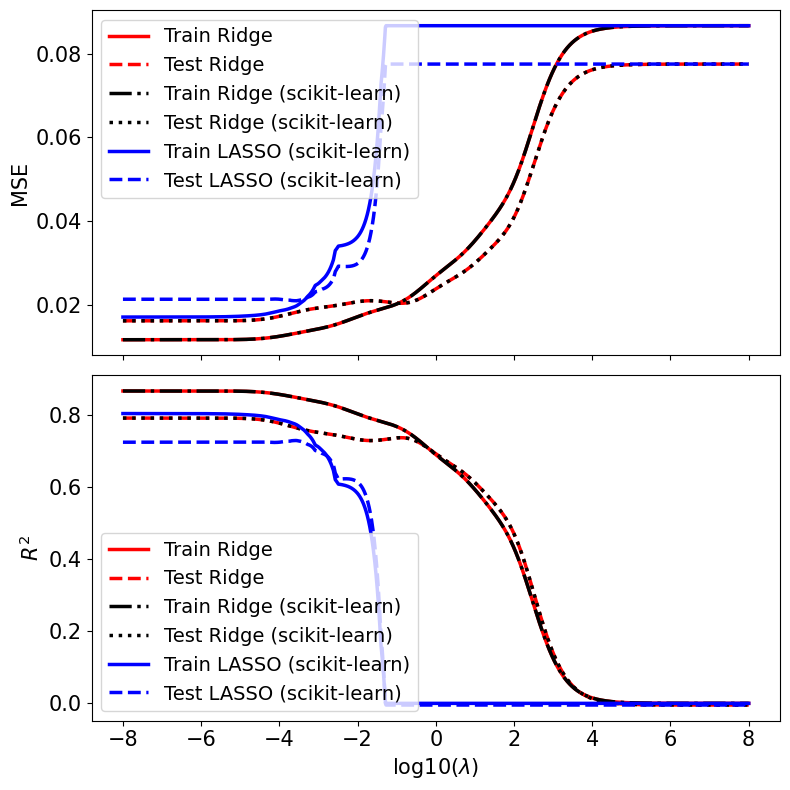

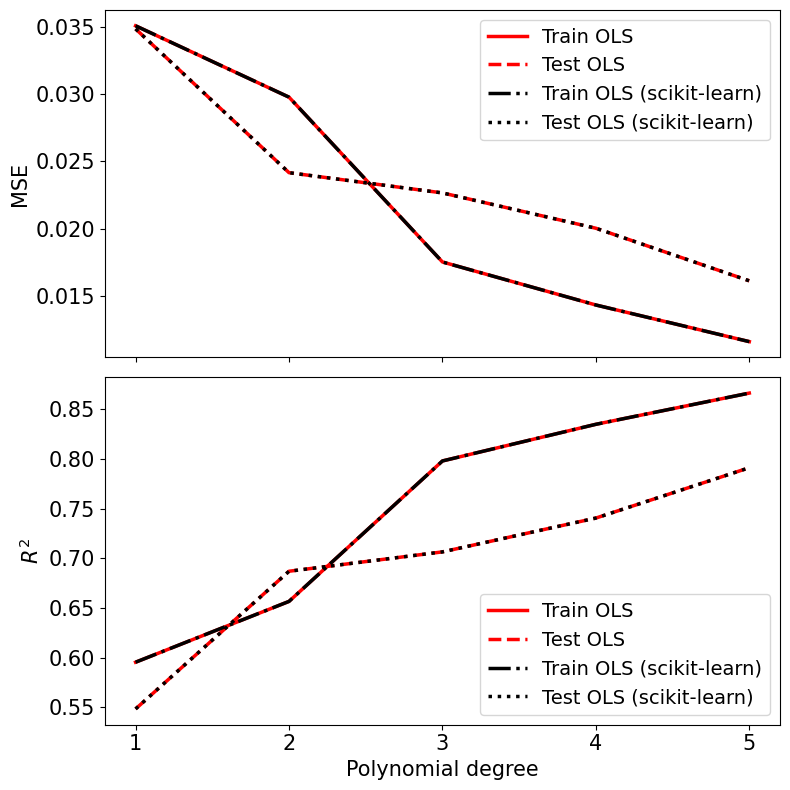

In [2]:
warnings.filterwarnings('ignore')

data,z=test_function(0.1,0.05)
#Using 80% of the sample size for training and reserving the remaining 20% for testing.
x_train, x_test, y_train, y_test = train_test_split(data, z, test_size=0.2)

#Calcultaing the parameters for the various regression methods.
Ridge_par= regression_methods(x_train, x_test, y_train, y_test,5,"Ridge")
LASSO_par= regression_methods(x_train, x_test, y_train, y_test,5,"LASSO")
Ridge_sklearn_par= regression_methods(x_train, x_test, y_train, y_test,5,"Ridge sklearn")
OLS_par= regression_methods(x_train, x_test, y_train, y_test,5,"OLS")
OLS_sklearn_par= regression_methods(x_train, x_test, y_train, y_test,5,"OLS sklearn") 

fig, axs = plt.subplots(2, sharex=True, sharey=False, squeeze=True,tight_layout=True,figsize=(8, 8))


axs[0].plot(Ridge_par[0],Ridge_par[1], label='Train Ridge', linewidth=2.5,color="red")
axs[0].plot(Ridge_par[0],Ridge_par[2], label='Test Ridge', linewidth=2.5,color="red",linestyle='--')
axs[0].plot(Ridge_sklearn_par[0],Ridge_sklearn_par[1], label='Train Ridge (scikit-learn)', 
         linewidth=2.5,color="black",linestyle='-.')
axs[0].plot(Ridge_sklearn_par[0],Ridge_sklearn_par[2], label='Test Ridge (scikit-learn)', 
         linewidth=2.5,color="black",linestyle=':')
axs[0].plot(LASSO_par[0],LASSO_par[1], label='Train LASSO (scikit-learn)', linewidth=2.5,color="blue")
axs[0].plot(LASSO_par[0],LASSO_par[2], label='Test LASSO (scikit-learn)', 
         linewidth=2.5,color="blue",linestyle='--')

axs[0].set_xlabel(r'log10$(\lambda)$',size=15)
axs[0].set_ylabel('MSE',size=15)
axs[0].legend(fontsize=14)
axs[0].tick_params(axis="y", labelsize=15) 
axs[0].tick_params(axis="x", labelsize=15) 
axs[0].label_outer()


axs[1].plot(Ridge_par[0],Ridge_par[3], label='Train Ridge', linewidth=2.5,color="red")
axs[1].plot(Ridge_par[0],Ridge_par[4], label='Test Ridge', linewidth=2.5,color="red",linestyle='--')
axs[1].plot(Ridge_sklearn_par[0],Ridge_sklearn_par[3], label='Train Ridge (scikit-learn)', 
         linewidth=2.5,color="black",linestyle='-.')
axs[1].plot(Ridge_sklearn_par[0],Ridge_sklearn_par[4], label='Test Ridge (scikit-learn)', 
         linewidth=2.5,color="black",linestyle=':')
axs[1].plot(LASSO_par[0],LASSO_par[3], label='Train LASSO (scikit-learn)', linewidth=2.5,color="blue")
axs[1].plot(LASSO_par[0],LASSO_par[4], label='Test LASSO (scikit-learn)', 
         linewidth=2.5,color="blue",linestyle='--')
axs[1].set_xlabel(r'log10$(\lambda)$',size=15)
axs[1].set_ylabel(r'$R^2$',size=15)
axs[1].legend(fontsize=14)
axs[1].tick_params(axis="x", labelsize=15) 
axs[1].tick_params(axis="y", labelsize=15)
axs[1].label_outer()
plt.savefig('MSE-R2-Ridge-LASSO.png',dpi=100, bbox_inches='tight')
plt.show()

fig, axs = plt.subplots(2, sharex=True, sharey=False, squeeze=True,tight_layout=True,figsize=(8, 8))
axs[0].plot(OLS_par[0],OLS_par[1], label='Train OLS', linewidth=2.5,color="red")
axs[0].plot(OLS_par[0],OLS_par[2], label='Test OLS', linewidth=2.5,color="red",linestyle='--')
axs[0].plot(OLS_sklearn_par[0],OLS_sklearn_par[1], label='Train OLS (scikit-learn)', 
         linewidth=2.5,color="black",linestyle='-.')
axs[0].plot(OLS_sklearn_par[0],OLS_sklearn_par[2], label='Test OLS (scikit-learn)', 
         linewidth=2.5,color="black",linestyle=':')

axs[0].set_xlabel('Polynomial degree p',size=15)
axs[0].set_ylabel('MSE',size=15)
axs[0].legend(fontsize=14)
axs[0].tick_params(axis="y", labelsize=15) 
axs[0].tick_params(axis="x", labelsize=15) 
axs[0].label_outer()

axs[1].plot(OLS_par[0],OLS_par[3], label='Train OLS', linewidth=2.5,color="red")
axs[1].plot(OLS_par[0],OLS_par[4], label='Test OLS', linewidth=2.5,color="red",linestyle='--')
axs[1].plot(OLS_sklearn_par[0],OLS_sklearn_par[3], label='Train OLS (scikit-learn)', 
         linewidth=2.5,color="black",linestyle='-.')
axs[1].plot(OLS_sklearn_par[0],OLS_sklearn_par[4], label='Test OLS (scikit-learn)', 
         linewidth=2.5,color="black",linestyle=':')
axs[1].set_xlabel('Polynomial degree',size=15)
axs[1].set_ylabel(r'$R^2$',size=15)
axs[1].legend(fontsize=14)
axs[1].tick_params(axis="x", labelsize=15) 
axs[1].set_xticks(np.arange(1,np.size(OLS_par[0])+1))
axs[1].tick_params(axis="y", labelsize=15)
axs[1].label_outer()
plt.savefig('MSE-R2-OLS.png',dpi=100, bbox_inches='tight')
plt.show()

#### Examining the influence of noise and regularization on the beta coefficients in Ridge and LASSO regression.

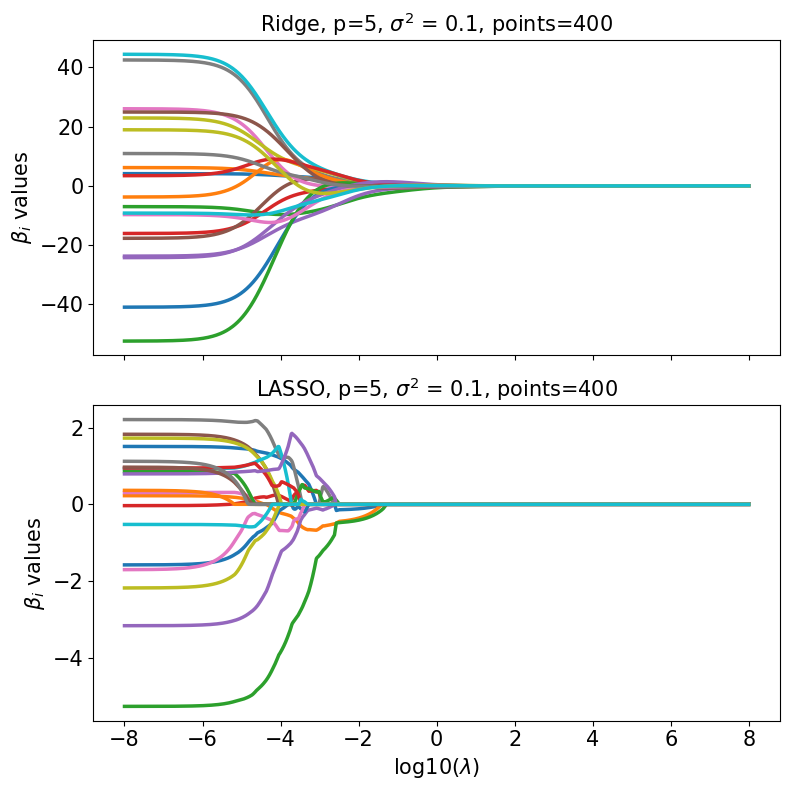

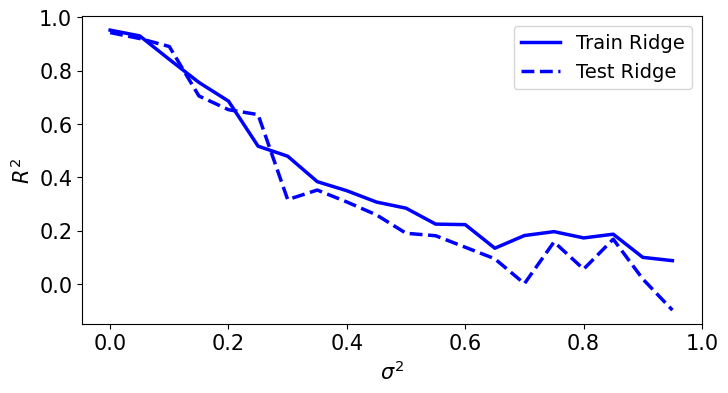

In [3]:
fig, axs = plt.subplots(2, sharex=True, sharey=False, squeeze=True,tight_layout=True,figsize=(8, 8))

axs[0].plot(Ridge_par[0],Ridge_par[5], linewidth=2.5)
axs[0].set_xlabel(r'log10$(\lambda)$',size=15)
axs[0].set_ylabel(r'$\beta_i$ values',size=15)
axs[0].tick_params(axis="y", labelsize=15) 
axs[0].tick_params(axis="x", labelsize=15)
axs[0].set_title("Ridge, "+"p=5, "+r'$\sigma^2$ = 0.1'+', points=400',size=15)
axs[0].label_outer()

axs[1].plot(LASSO_par[0],LASSO_par[5], linewidth=2.5)
axs[1].set_xlabel(r'log10$(\lambda)$',size=15)
axs[1].set_ylabel(r'$\beta_i$ values',size=15)
axs[1].tick_params(axis="y", labelsize=15) 
axs[1].tick_params(axis="x", labelsize=15) 
axs[1].set_xticks([2*i for i in range(-4,5) ])
axs[1].set_title("LASSO, "+"p=5, "+r'$\sigma^2$ = 0.1'+', points=400',size=15)
axs[1].label_outer()

plt.savefig('Ridge-LASSO-beta_values.png',dpi=100, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 4))

sigma=np.arange(0, 1, 0.05)
r2=[]
for i in range(len(sigma)):
    data,z=test_function(sigma[i],0.05)
    x_train, x_test, y_train, y_test = train_test_split(data, z, test_size=0.2)
    r2.append(Ridge_noise(x_train, x_test, y_train, y_test,5,0.001))
r2=np.stack(r2)

plt.plot(sigma,r2[:,0],color="blue", label='Train Ridge', linewidth=2.5)
plt.plot(sigma,r2[:,1],color="blue",linestyle='--', label='Test Ridge', linewidth=2.5)
plt.xlabel(r'$\sigma^2$',size=15)
plt.ylabel(r'$R^2$',size=15)
plt.xticks([(i/5) for i in range(6) ],fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=14)
plt.savefig('Noise-R2.png',dpi=100, bbox_inches='tight')

plt.show()

#### Bias and variance of Ordinary Least Squares (OLS).

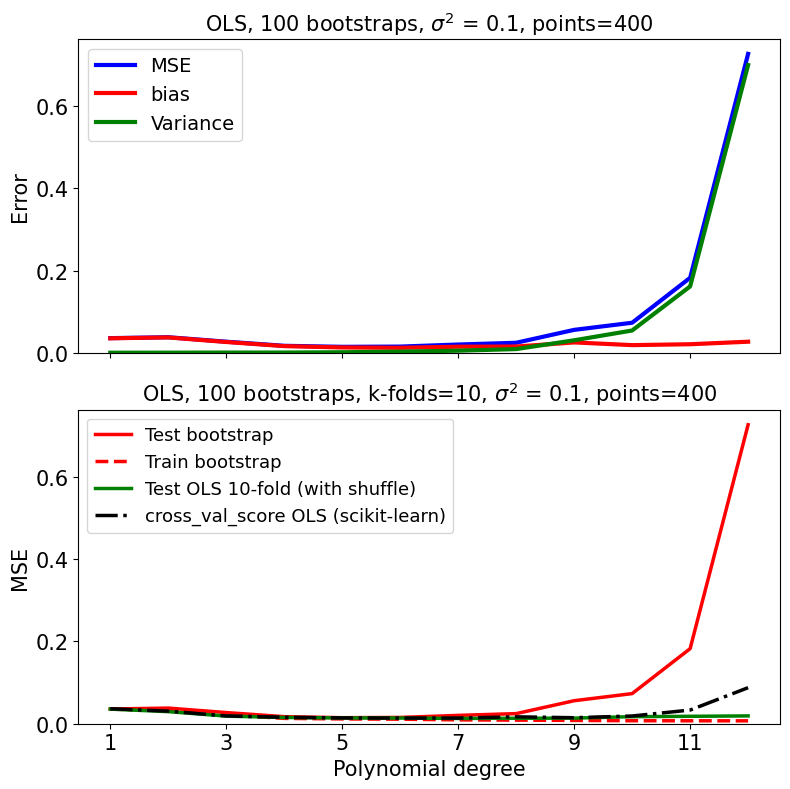

In [4]:
data,z=test_function(0.1,0.05)
x_train, x_test, y_train, y_test = train_test_split(data, z, test_size=0.2)

degree_p,error,bias,variance,test_error,train_error,bootstap_values=bootstraps(100,12,"OLS",x_train, x_test, y_train, y_test,"False")

fig, axs = plt.subplots(2, sharex=True, sharey=True, squeeze=True,tight_layout=True,figsize=(8, 8))
axs[0].plot(degree_p,error, label='MSE', linewidth=3,color="blue")
axs[0].plot(degree_p,bias, label='bias', linewidth=3,color="red")
axs[0].plot(degree_p,variance, label='Variance', linewidth=3,color="green")

axs[0].set_xlabel('Polynomial degree',size=15)
axs[0].set_ylabel('Error',size=15)
axs[0].legend(fontsize=14)
axs[0].tick_params(axis="y", labelsize=15) 
axs[0].tick_params(axis="x", labelsize=15) 
axs[0].set_xticks([1,3,5,7,9,11])
axs[0].label_outer()
axs[0].set_title("OLS, 100 bootstraps, "+r'$\sigma^2$ = 0.1'+', points=400',size=15)

axs[1].set_title("OLS, 100 bootstraps, k-folds=10, "+r'$\sigma^2$ = 0.1'+', points=400',size=15)
axs[1].plot(degree_p,test_error, label='Test bootstrap', linewidth=2.5,color="red")
axs[1].plot(degree_p,train_error, label='Train bootstrap', linewidth=2.5,color="red",linestyle='--')
axs[1].set_xlabel('Polynomial degree',size=15)
axs[1].set_ylabel('MSE',size=15)
axs[1].legend(fontsize=14)
axs[1].tick_params(axis="x", labelsize=15) 
axs[1].set_xticks([1,3,5,7,9,11])
axs[1].tick_params(axis="y", labelsize=15)
axs[1].label_outer()
axs[1].set_ylim([0,max(error)*1.05])

Lambdas,estimated_mse_KFold_train,estimated_mse_KFold_test=K_fold(z,12,10,"OLS")
plt.plot(Lambdas, estimated_mse_KFold_test, label = 'Test OLS 10-fold (with shuffle)', linewidth=2.5,color="green",linestyle='-')

Lambdas,estimated_mse_sklearn=cross_val(data,z,"OLS",12)
plt.plot(Lambdas,estimated_mse_sklearn, linewidth=2.5,linestyle='-.', 
         label = 'cross_val_score OLS (scikit-learn)',color="black")
axs[1].legend(fontsize=13)
plt.savefig('Bias_variance_tradeoff-MSE.png',dpi=100, bbox_inches='tight')
plt.show()

#### Calculating the Mean Squared Error (MSE) for Ridge and LASSO using resampling techniques  bootstrapping and k-fold cross-validation.

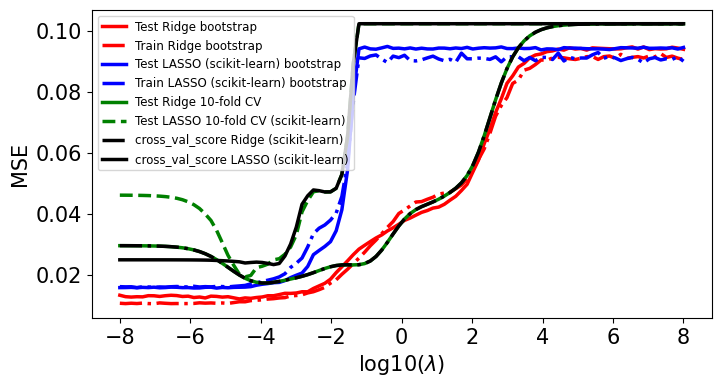

In [5]:
data,z=test_function(0.1,0.05)
x_train, x_test, y_train, y_test = train_test_split(data, z, test_size=0.2)

plt.figure(figsize=(8, 4))

degree_p,error,bias,variance,test_error,train_error,bootstap_values=bootstraps(100,5,"Ridge",x_train, x_test, y_train, y_test,"False")
plt.plot(degree_p,test_error, label='Test Ridge bootstrap', linewidth=2.5,color="red")
plt.plot(degree_p,train_error, label='Train Ridge bootstrap', linewidth=2.5,color="red",linestyle='-.')
plt.legend(fontsize=9)

degree_p,error,bias,variance,test_error,train_error,bootstap_values=bootstraps(100,5,"LASSO",x_train, x_test, y_train, y_test,"False")
plt.plot(degree_p,test_error, label='Test LASSO (scikit-learn) bootstrap', linewidth=2.5,color="blue")
plt.plot(degree_p,train_error, label='Train LASSO (scikit-learn) bootstrap', linewidth=2.5,color="blue",linestyle='-.')
plt.legend(fontsize=9)

Lambdas,estimated_mse_KFold_train,estimated_mse_KFold_test=K_fold(z,5,10,"Ridge")
plt.plot(Lambdas, estimated_mse_KFold_test, label = 'Test Ridge 10-fold CV', linewidth=2.5,color="green",linestyle='-')
plt.legend(fontsize=9)

Lambdas,estimated_mse_KFold_train,estimated_mse_KFold_test=K_fold(z,10,5,"LASSO")
plt.plot(Lambdas, estimated_mse_KFold_test, label = 'Test LASSO 10-fold CV (scikit-learn)', 
         linewidth=2.5,color="green",linestyle='--')
plt.legend(fontsize=9)

plt.xlabel(r'log10($\lambda$)',size=15)
plt.ylabel("MSE",size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=9)

Lambdas,estimated_mse_sklearn=cross_val(data,z,"Ridge",5)
plt.plot(Lambdas,estimated_mse_sklearn, linewidth=2.5,linestyle='-.', 
         label = 'cross_val_score Ridge (scikit-learn)',color="black")
Lambdas,estimated_mse_sklearn=cross_val(data,z,"LASSO",5)
plt.plot(Lambdas,estimated_mse_sklearn, linewidth=2.5,linestyle='-', 
         label = 'cross_val_score LASSO (scikit-learn)',color="black")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=8.5)
plt.savefig('Ridge_LASSO-comparison.png',dpi=100, bbox_inches='tight')
plt.show()

#### Confidence intervals for the beta coefficients.

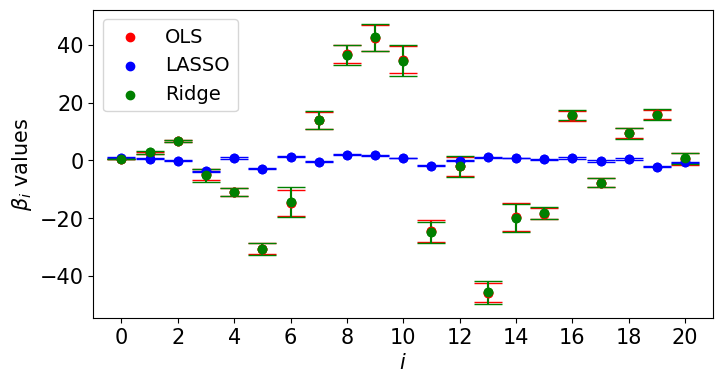

In [6]:
data,z=test_function(0.1,0.01)
x_train, x_test, y_train, y_test = train_test_split(data, z, test_size=0.2)

degree_p,error,bias,variance,test_error,train_error,bootstrap_beta_values=bootstraps(100,5,"OLS",x_train, x_test, y_train, y_test,"True")

beta_values=np.stack(bootstrap_beta_values[0])
mean_beta_values=np.mean(beta_values,axis=0)
err_beta_values=np.std(beta_values,axis=0)
n_beta=np.arange(len(mean_beta_values))

plt.figure(figsize=(8, 4))
plt.scatter(n_beta, mean_beta_values,color="red",label="OLS")
plt.errorbar(n_beta, mean_beta_values, yerr=1.96*err_beta_values, fmt="o",color="red",ecolor='red',capsize=10)

degree_p,error,bias,variance,test_error,train_error,bootstrap_beta_values=bootstraps(100,5,"LASSO",x_train, x_test, y_train, y_test,"True")

beta_values=np.stack(bootstrap_beta_values[0])
mean_beta_values=np.mean(beta_values,axis=0)
err_beta_values=np.std(beta_values,axis=0)

plt.scatter(n_beta, mean_beta_values,color="blue",label="LASSO")
plt.errorbar(n_beta, mean_beta_values, yerr=1.96*err_beta_values, fmt="o",color="blue",ecolor='blue',capsize=10)

degree_p,error,bias,variance,test_error,train_error,bootstrap_beta_values=bootstraps(100,5,"Ridge",x_train, x_test, y_train, y_test,"True")

beta_values=np.stack(bootstrap_beta_values[0])
mean_beta_values=np.mean(beta_values,axis=0)
err_beta_values=np.std(beta_values,axis=0)

plt.scatter(n_beta, mean_beta_values,color="green",label="Ridge")
plt.errorbar(n_beta, mean_beta_values, yerr=1.96*err_beta_values, fmt="o",color="green",ecolor='green',capsize=10)
plt.xticks(np.arange(len(mean_beta_values)/2)*2)

plt.legend(fontsize=14)
plt.tick_params(axis="x", labelsize=15) 
plt.tick_params(axis="y", labelsize=15)
plt.xlabel(r'$i$',size=15)
plt.ylabel(r'$\beta_i$ values',size=15)
plt.savefig('Error_bar-beta_values.png',dpi=100, bbox_inches='tight')
plt.show()

#### Investigating various configurations for OLS, Ridge, and LASSO.

In [7]:
warnings.filterwarnings('ignore')
method_conf=[[0,0.1],[0,0.1],[0,0.1],[0,0.05],[0.1,0.05],[0.5,0.05],[0,0.01],[0.1,0.01],[0.5,0.01]]
mse_lambda_array=np.zeros((9,5))
for i in range(9): 
    data,z=test_function(method_conf[i][0],method_conf[i][1])
    x_train, x_test, y_train, y_test = train_test_split(data, z, test_size=0.1)
    mse_lambda_array[i][0],mse_lambda_array[i][1]=np.around(bootstraps(100,5,"Ridge",x_train, x_test, y_train, y_test,"True")[6][1:3],16)
    mse_lambda_array[i][2],mse_lambda_array[i][3]=np.around(bootstraps(100,5,"LASSO",x_train, x_test, y_train, y_test,"True")[6][1:3],16)
    mse_lambda_array[i][4]=np.around(bootstraps(100,5,"OLS",x_train, x_test, y_train, y_test,"True")[6][1:3],16)
    
    sys.stdout.write('\r')
    sys.stdout.write("[%-9s] %d%%" % ('='*(i+1), (100/9)*(i+1)))
    sys.stdout.flush()

data = {'Method/config':[r'$n=100, \sigma^2=0$', r'$n=100, \sigma^2=0.1$', r'$n=100,\sigma^2=0.5$',
                         r'$n=400 \sigma^2=0$', r'$n=400, \sigma^2=0.1$', r'$n=400,\sigma^2=0.5$', 
                         r'$n=10000,\sigma^2=0$', r'$n=10000,\sigma^2=0.1$', r'$n=10000,\sigma^2=0.5$'],
        r'$\lambda$(Ridge)':["{:.1e}".format(i) for i in mse_lambda_array[:,1]],
        'Ridge(MSE)':["{:.1e}".format(i) for i in mse_lambda_array[:,0]],        
        r'$\lambda$(LASSO)':["{:.1e}".format(i) for i in mse_lambda_array[:,3]],
        'LASSO(MSE)':["{:.1e}".format(i) for i in mse_lambda_array[:,2]],        
        'OLS(MSE)':["{:.1e}".format(i) for i in mse_lambda_array[:,4]]}

df_Franke = pd.DataFrame(data)
print("\nBest results for the Franke function (p=5), bootstraps=100: ") 
print("------------------------------------------")  
display(df_Franke)

[=========] 100%
Best results for the Franke function (p=5), bootstraps=100: 
------------------------------------------


,Method/config,$\lambda$(Ridge),Ridge(MSE),$\lambda$(LASSO),LASSO(MSE),OLS(MSE)
0,"$n=100, \sigma^2=0$",4.5e-07,4.7e-03,3.9e-05,6.4e-03,1.0e-02
1,"$n=100, \sigma^2=0.1$",1.6e-06,2.9e-03,1.1e-05,8.7e-03,3.0e-03
2,"$n=100,\sigma^2=0.5$",2.0e-05,2.2e-03,1.0e-08,3.8e-03,3.3e-03
3,$n=400 \sigma^2=0$,1.9e-08,1.6e-03,8.5e-07,5.7e-03,1.6e-03
4,"$n=400, \sigma^2=0.1$",3.0e-06,1.1e-02,8.5e-07,1.4e-02,1.1e-02
5,"$n=400,\sigma^2=0.5$",9.2e-04,2.4e-01,2.8e-01,2.3e-01,2.8e-01
6,"$n=10000,\sigma^2=0$",3.9e-05,2.2e-03,2.4e-07,7.4e-03,2.2e-03
7,"$n=10000,\sigma^2=0.1$",1.1e-05,1.1e-02,3.6e-08,1.6e-02,1.1e-02
8,"$n=10000,\sigma^2=0.5$",2.0e-05,2.4e-01,4.5e-07,2.5e-01,2.4e-01


#### Applying Ridge regression to fit the Franke's function.

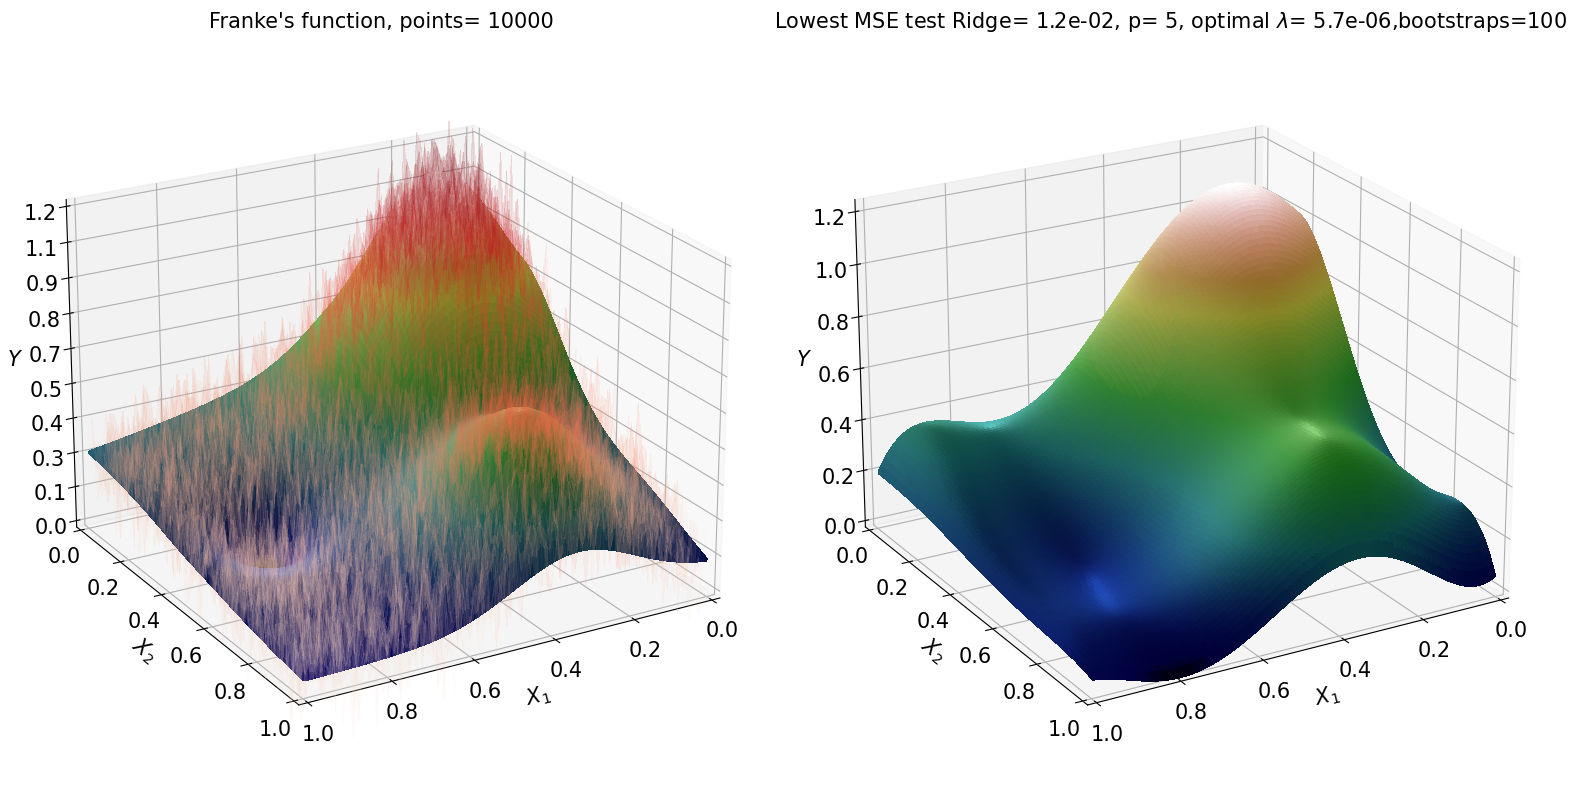

In [8]:
h=0.01
data,z=test_function(0,h)
z=z.reshape(int(1/h),int(1/h))
x=data[:,0].reshape(int(1/h),int(1/h))
y=data[:,1].reshape(int(1/h),int(1/h))

fig = plt.figure(figsize=(16, 8),tight_layout=True)
#Customizing a plot for the data of the Franke function
ls = LightSource(270, 45)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=1000, blend_mode='soft')
surf = ax1.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=3, antialiased=False, shade=False)
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.01f'))
ax1.view_init(22, 60)
ax1.set_zlim(0, 1.22)
ax1.view_init(22, 60)
ax1.set_xlabel(r'$X_1$',size=15)
ax1.set_ylabel(r'$X_2$',size=15)
ax1.set_zlabel(r'$Y$',size=15)
ax1.tick_params(axis="x", labelsize=15) 
ax1.tick_params(axis="y", labelsize=15) 
ax1.tick_params(axis="z", labelsize=15) 
ax1.set_zticks(np.linspace(0,1.2,7))
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_title("Franke's function, points= 10000",size=15)
h=0.01
#Adding noise to the Franke's function
data,z=test_function(0.1,h)
z_mesh=z.reshape(int(1/h),int(1/h))

x_mesh=data[:,0].reshape(int(1/h),int(1/h))
y_mesh=data[:,1].reshape(int(1/h),int(1/h))

surf = ax1.plot_surface(x_mesh, y_mesh, z_mesh, rstride=1, cstride=1,
                       linewidth=3, antialiased=False, shade=False,alpha=0.05, cmap=cm.Reds)
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.01f'))

plt.tight_layout()

x_train, x_test, y_train, y_test = train_test_split(data, z, test_size=0.2)

degree_p,error,bias,variance,test_error,train_error,bootstrap_beta_values=bootstraps(100,5,"Ridge",x_train, x_test, y_train, y_test,"True")

beta_values=np.stack(bootstrap_beta_values[0])
mean_beta_values=np.mean(beta_values,axis=0)

X=feature_matrix(data[:,0],data[:,1],5)

Y=np.dot(X,mean_beta_values[1:21])+mean_beta_values[0]
z=Y.reshape(int(1/h),int(1/h))

x2=X[:,1].reshape(int(1/h),int(1/h))
x1=X[:,0].reshape(int(1/h),int(1/h))


ls = LightSource(270, 45)
ax = fig.add_subplot(1, 2, 2, projection='3d')
rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=1000, blend_mode='soft')
surf = ax.plot_surface(x1, x2, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=3, antialiased=False, shade=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.01f'))
ax.view_init(22, 60)
ax.set_zlim(0, 1.22)
ax.view_init(22, 60)
ax.set_xlabel(r'$X_1$',size=15)
ax.set_ylabel(r'$X_2$',size=15)
ax.set_zlabel(r'$Y$',size=15)
ax.tick_params(axis="x", labelsize=15) 
ax.tick_params(axis="y", labelsize=15) 
ax.tick_params(axis="z", labelsize=15) 
ax.set_zticks(np.linspace(0,1.2,7))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title("Lowest MSE test Ridge= {:.1e}".format(bootstrap_beta_values[1])+", p= 5, "+
             r"optimal $\lambda$= {:.1e}".format(bootstrap_beta_values[2])+
             ",bootstraps=100",size=15)
plt.savefig('Franke_fit.png',dpi=100, bbox_inches='tight')
plt.tight_layout()

## Digital terrain data

#### The terrain data's Mean Squared Error (MSE), bias, and variance.

The entire terrain:  Minimum altitude:  50 Maximum altitude:  1865
Custom terrain:  Minimum altitude:  193.0 Maximum altitude:  1865.0
[============================================================] 100%

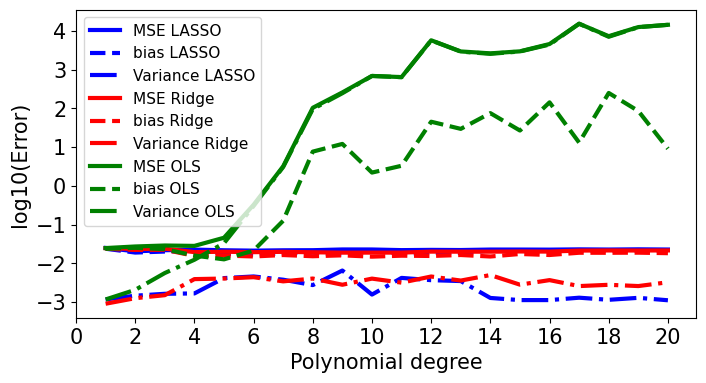

Best terrain results, points=100, bootstraps=100:
------------------------------------------


,p,$\lambda$(LASSO),LASSO(MSE),LASSO(bias),LASSO(var),$\lambda$(Ridge),Ridge(MSE),Ridge(bias),Ridge(var),OLS(MSE),OLS(bias),OLS(var)
0,1,1.7e-03,2.5e-02,2.4e-02,1.2e-03,1.0e+00,2.5e-02,2.4e-02,9.0e-04,2.5e-02,2.4e-02,1.2e-03
1,2,1.7e-03,2.0e-02,1.9e-02,1.5e-03,5.3e-01,2.3e-02,2.2e-02,1.3e-03,2.7e-02,2.5e-02,2.1e-03
2,3,3.3e-03,2.2e-02,2.0e-02,1.6e-03,1.0e+00,2.4e-02,2.2e-02,1.5e-03,2.9e-02,2.3e-02,5.6e-03
3,4,3.3e-03,2.3e-02,2.1e-02,1.7e-03,2.6e-04,1.9e-02,1.6e-02,3.9e-03,2.8e-02,1.6e-02,1.2e-02
4,5,3.9e-05,2.2e-02,1.8e-02,4.2e-03,1.7e-03,2.0e-02,1.6e-02,4.0e-03,4.6e-02,1.3e-02,3.3e-02
5,6,3.9e-05,2.1e-02,1.7e-02,4.6e-03,1.7e-03,1.9e-02,1.5e-02,4.4e-03,3.2e-01,2.1e-02,3.0e-01
6,7,1.4e-04,2.2e-02,1.8e-02,3.8e-03,4.2e-02,2.0e-02,1.6e-02,3.4e-03,3.2e+00,1.3e-01,3.1e+00
7,8,2.6e-04,2.2e-02,1.9e-02,2.7e-03,2.2e-02,1.9e-02,1.5e-02,4.0e-03,1.0e+02,7.7e+00,9.6e+01
8,9,7.3e-05,2.3e-02,1.6e-02,6.5e-03,7.9e-02,1.9e-02,1.6e-02,2.8e-03,2.6e+02,1.2e+01,2.5e+02
9,10,3.3e-03,2.3e-02,2.1e-02,1.6e-03,4.2e-02,1.9e-02,1.5e-02,4.0e-03,6.9e+02,2.2e+00,6.9e+02


In [9]:
warnings.filterwarnings('ignore')
#Getting the coordinates from a section of the terrain data.
x_mesh, y_mesh,z_mesh=terrain_data()
n=10
data=np.zeros((n*n, 2))

random_index=np.arange(400*400)
random_index=np.random.choice(random_index, size=n*n, replace=False)
data[:,0]=x_mesh.flatten()[random_index]
data[:,1]=y_mesh.flatten()[random_index]
z=z_mesh.flatten()[random_index]

x_train, x_test, y_train, y_test = train_test_split(data, z, test_size=0.2)

plt.figure(figsize=(8, 4))

#Saving the optimal lambda and MSE test values for future analysis.
model_lambdas=[[0]]*2
model_errors=[[0]]*3
model_bias=[[0]]*3
model_variance=[[0]]*3
k=0
for i in range(3):
    d=[]
    E=[]
    Bias=[]
    Lambdas=[]
    Variance=[]
    for j in range(1,21):
        k+=1
        sys.stdout.write('\r')
        sys.stdout.write("[%-60s] %d%%" % ('='*k, (100/60)*k))
        sys.stdout.flush()
        
        if i==0:
            lamda,error,bias,variance,test_error,train_error,bootstap_values=bootstraps(100,j,"LASSO",x_train, x_test, y_train, y_test,"True")
        if i==1:
            lamda,error,bias,variance,test_error,train_error,bootstap_values=bootstraps(100,j,"Ridge",x_train, x_test, y_train, y_test,"True")
        if i==2:
            degree_p,error,bias,variance,test_error,train_error,bootstap_values=bootstraps(100,j,"OLS",x_train, x_test, y_train, y_test,"True")

            E.append(error[-1])
            Bias.append(bias[-1])
            Variance.append(variance[-1])
            d.append(j)
        if i==0 or i==1:
            d.append(j)
            E.append(min(error))
            lowest_index=np.where(error==min(error))[0][0]
            Bias.append(bias[lowest_index])
            Lambdas.append(lamda[lowest_index])
            Variance.append(variance[lowest_index])
            
    if i==0:
        plt.plot(d,np.log10(E), label='MSE LASSO', linewidth=3,color="blue")
        plt.plot(d,np.log10(Bias), label='bias LASSO', linewidth=3,color="blue",linestyle='--')
        plt.plot(d,np.log10(Variance), label='Variance LASSO', linewidth=3,color="blue",linestyle='-.')
    if i==1:
        plt.plot(d,np.log10(E), label='MSE Ridge', linewidth=3,color="red")
        plt.plot(d,np.log10(Bias), label='bias Ridge', linewidth=3,color="red",linestyle='--')
        plt.plot(d,np.log10(Variance), label='Variance Ridge', linewidth=3,color="red",linestyle='-.')
    if i==2:
        plt.plot(d,np.log10(E), label='MSE OLS', linewidth=3,color="green")
        plt.plot(d,np.log10(Bias), label='bias OLS', linewidth=3,color="green",linestyle='--')
        plt.plot(d,np.log10(Variance), label='Variance OLS', linewidth=3,color="green",linestyle='-.')
        
    if i==0 or i==1:
        model_lambdas[i]=Lambdas
    model_errors[i]=E
    model_bias[i]=Bias
    model_variance[i]=Variance
        

plt.xlabel('Polynomial degree',size=15)
plt.ylabel('log10(Error)',size=15)
plt.legend(fontsize=11)
plt.xticks(size=15) 
plt.yticks(size=15) 
plt.xticks(np.arange(11)*2)
plt.savefig('best_results-terrain.png',dpi=100, bbox_inches='tight')
plt.show()

data = {'p':d,
        r'$\lambda$(LASSO) ':["{:.1e}".format(i) for i in 10**np.array(model_lambdas[0])],
        'LASSO(MSE)':["{:.1e}".format(i) for i in model_errors[0]],
        'LASSO(bias)':["{:.1e}".format(i) for i in model_bias[0]],
        'LASSO(var)':["{:.1e}".format(i) for i in model_variance[0]],
        r'$\lambda$(Ridge)':["{:.1e}".format(i) for i in 10**np.array(model_lambdas[1])],
        'Ridge(MSE)':["{:.1e}".format(i) for i in model_errors[1]],
        'Ridge(bias)':["{:.1e}".format(i) for i in model_bias[1]],
        'Ridge(var)':["{:.1e}".format(i) for i in model_variance[1]],
        'OLS(MSE)':["{:.1e}".format(i) for i in model_errors[2]],
        'OLS(bias)':["{:.1e}".format(i) for i in model_bias[2]],
        'OLS(var)':["{:.1e}".format(i) for i in model_variance[2]],}

df_terrain = pd.DataFrame(data)
print("Best terrain results, points=100, bootstraps=100:") 
print("------------------------------------------") 

display(df_terrain)

#### Using Ordinary Least Squares (OLS) for terrain data modeling and implementing bootstrapping to determine optimal values, the results are then assessed through k-fold cross-validation.

[=====================================   ] 92%

<Figure size 640x480 with 0 Axes>

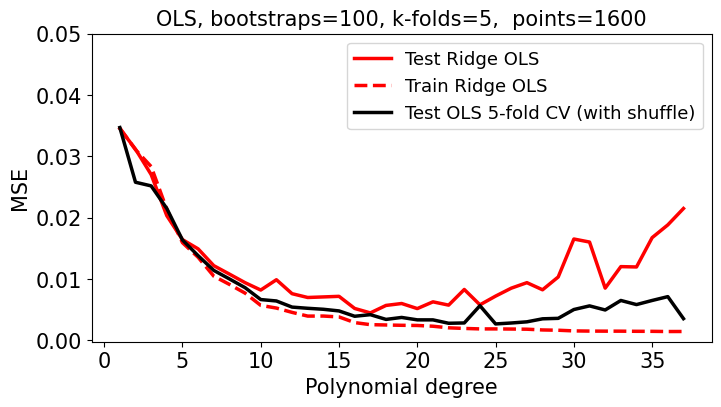

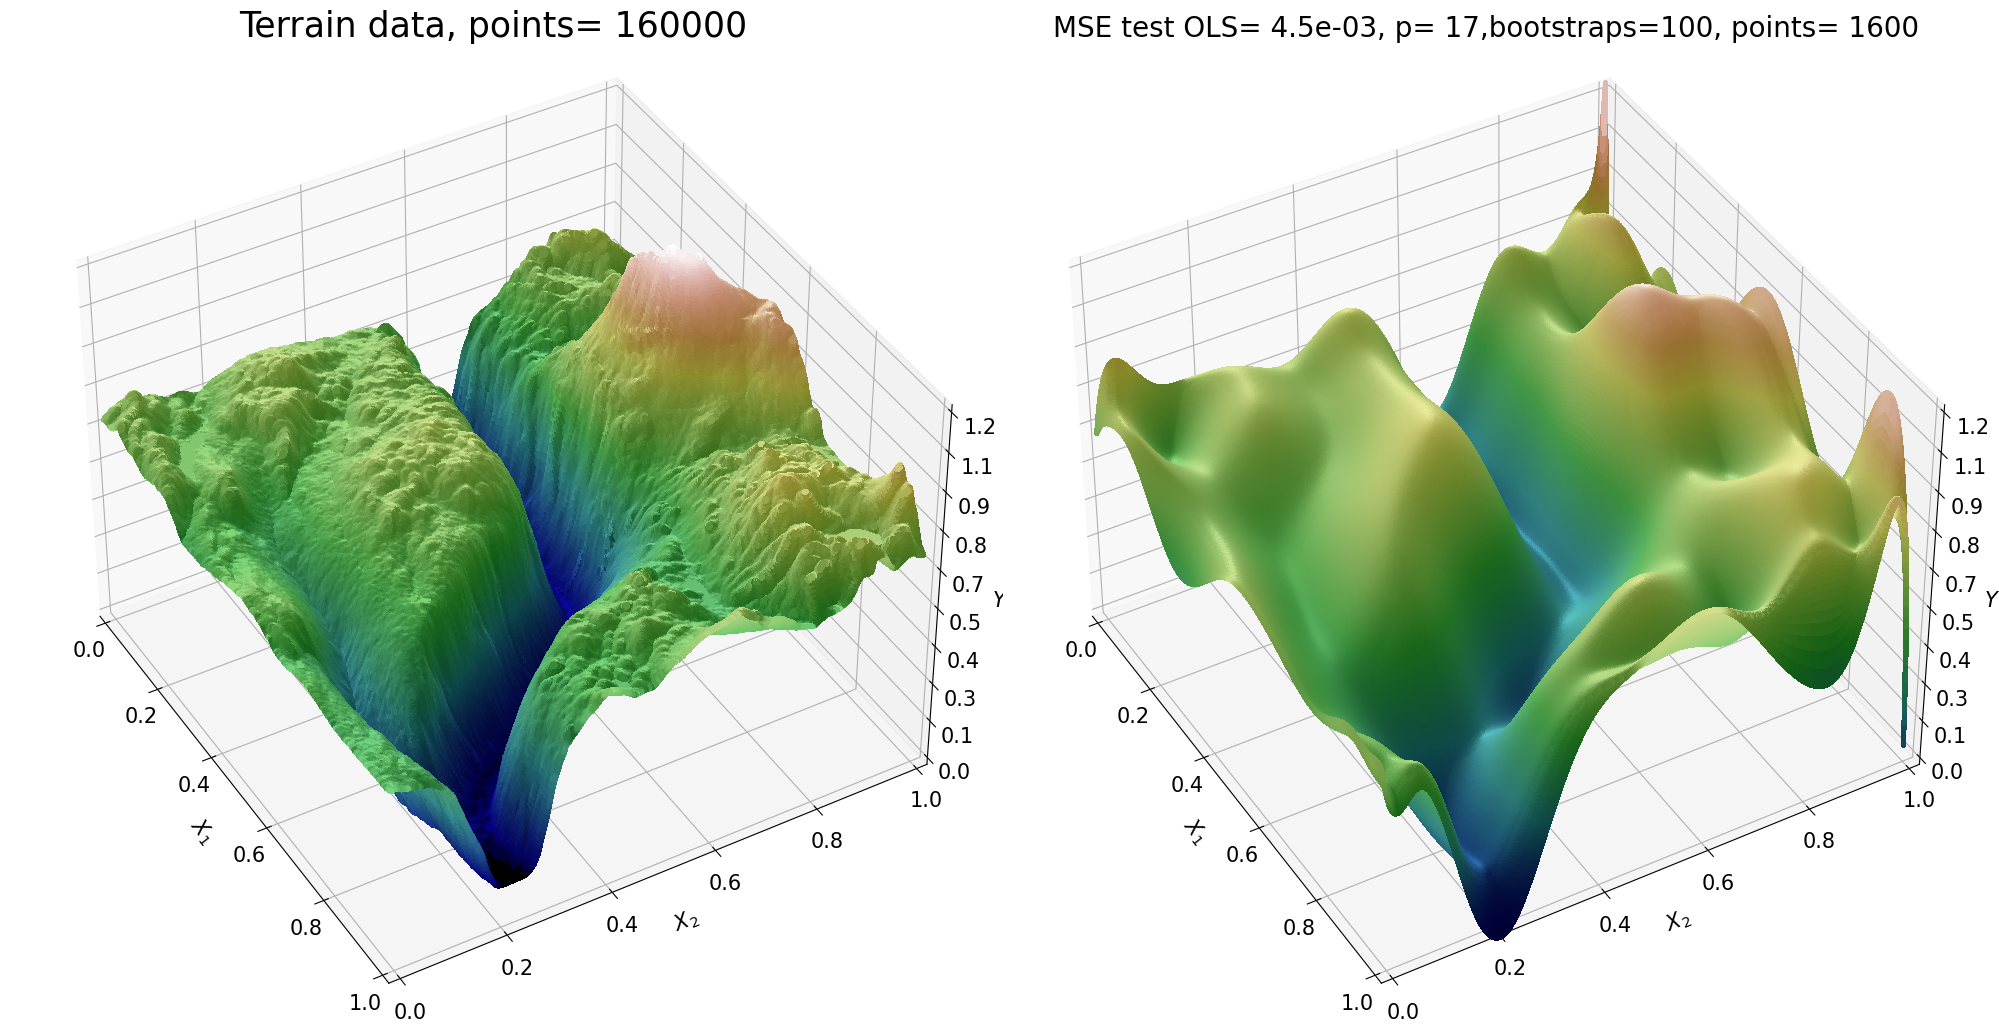

In [10]:

n=40
data=np.zeros((n*n, 2))
#choosing 1600 data points (40x40) from the custom dataset, which is 400x400
random_index=np.arange(400*400)
random_index=np.random.choice(random_index, size=n*n, replace=False)
data[:,0]=x_mesh.flatten()[random_index]
data[:,1]=y_mesh.flatten()[random_index]
z=z_mesh.flatten()[random_index]

x_train, x_test, y_train, y_test = train_test_split(data, z, test_size=0.2)
plt.figure()
degree_p=[]
test_OLS=[]
train_OLS=[]
worst_mse=0
best_mse=1
i=0
while worst_mse<0.02:
    i+=1
    #Using the bootstrapping method to determine the mean values of the 
    #beta coefficients and calculating the Mean Squared Error (MSE).
    bootstraps_par=bootstraps(100,i,"OLS",x_train, x_test, y_train, y_test,"True")
    degree_p.append(i)
    test_OLS.append(bootstraps_par[4][-1])
    train_OLS.append(bootstraps_par[5][-1])
    if test_OLS[-1]<best_mse:
        best_mse=test_OLS[-1]
        bootstrap_beta_values=bootstraps_par[6]
        n=i
    
    if i>10:
        worst_mse=max(test_OLS[9:])
    if i<41:
        #Requires approximately 40 iterations.
        sys.stdout.write('\r')
        sys.stdout.write("[%-40s] %d%%" % ('='*i, 2.5*i))
        sys.stdout.flush()
    
#Applying the k-fold cross-validation method to validate the results obtained through the bootstrapping method.       
estimated_mse_KFold_test=(K_fold(z,i,5,"OLS")[2])
plt.figure(figsize=(8, 4))
plt.plot(degree_p,test_OLS, label='Test Ridge OLS', linewidth=2.5,color="red")
plt.plot(degree_p,train_OLS, label='Train Ridge OLS', linewidth=2.5,color="red",linestyle='--')
plt.plot(degree_p, estimated_mse_KFold_test, label = 'Test OLS 5-fold CV (with shuffle)', linewidth=2.5,color="black",linestyle='-')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=13)
plt.xlabel('Polynomial degree',size=15)
plt.ylabel("MSE",size=15)
plt.title("OLS, bootstraps=100, k-folds=5, "+' points=1600',size=15)
plt.yticks([0,0.01,0.02,0.03,0.04,0.05])
plt.savefig('Terrain_OLS.png',dpi=100, bbox_inches='tight')
plt.show()

beta_values=np.stack(bootstrap_beta_values[0])
mean_beta_values=np.mean(beta_values,axis=0)

data=np.zeros((np.shape(x_mesh.flatten())[0], 2))
data[:,0]=x_mesh.flatten()
data[:,1]=y_mesh.flatten()
X=feature_matrix(data[:,0],data[:,1],n)

#Using the mean beta coefficients obtained from the lowest 
#test Mean Squared Error (MSE) on the custom dataset.
Y=np.dot(X,mean_beta_values[1:int((n+1)*(n+2)/2)])+mean_beta_values[0]

h=400
Y=Y.reshape(h,h)

x2=X[:,1].reshape(h,h)
x1=X[:,0].reshape(h,h)
fig = plt.figure(figsize=(20, 10),tight_layout=True)

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ls = LightSource(270, 45)
rgb = ls.shade(z_mesh, cmap=cm.gist_earth, vert_exag=1000, blend_mode='soft')
surf = ax1.plot_surface(x_mesh, y_mesh, z_mesh, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=3, antialiased=False, shade=False)
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.01f'))
ax1.set_title("Terrain data, points= 160000",size=25)
ax1.set_xlabel(r'$X_1$',size=15)
ax1.set_ylabel(r'$X_2$',size=15)
ax1.set_zlabel(r'$Y$',size=15)
ax1.tick_params(axis="x", labelsize=15) 
ax1.tick_params(axis="y", labelsize=15) 
ax1.tick_params(axis="z", labelsize=15) 
ax1.set_zticks(np.linspace(0,1.2,7))
ax1.view_init(40, -30)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_zticks([0])

ax = fig.add_subplot(1, 2, 2, projection='3d',sharex = ax1,sharey = ax1,sharez = ax1)
rgb = ls.shade(Y, cmap=cm.gist_earth, vert_exag=1000, blend_mode='soft')
surf = ax.plot_surface(x1, x2, Y, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=3, antialiased=False, shade=False)
ax.set_zlim(0, 1.22)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zticks(np.linspace(0,1.2,7))
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.01f'))
ax.set_xlabel(r'$X_1$',size=15)
ax.set_ylabel(r'$X_2$',size=15)
ax.set_zlabel(r'$Y$',size=15)
ax.view_init(40, -30)
ax.tick_params(axis="x", labelsize=15) 
ax.tick_params(axis="y", labelsize=15) 
ax.tick_params(axis="z", labelsize=15) 
ax.set_title("MSE test OLS= "+"{:.1e}".format(best_mse)+", p= "+str(n)+",bootstraps=100, points= 1600",size=20)
plt.savefig('Terrain_fit.png',dpi=100, bbox_inches='tight')
plt.show()